# Step 0: Tải các thư viện cần thiết cho bài báo cáo

In [1]:
!pip install underthesea
!pip install gensim

# Step 1: Dependencies import

In [15]:
import pandas as pd
import numpy as np
import string
import random

import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

from underthesea import word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


# Step 2: Data synthesis


In [16]:
np.random.seed(42)

# Define question categories
question_types = [
    "Thông tin chung", "Chiến thuật", "Cầu thủ & Đội bóng", "Lịch sử", "Sự kiện & Giải đấu", "Phân tích trận đấu", "Huấn luyện viên", "Kỹ năng cá nhân", "Chiến thuật đội bóng", "Phong cách thi đấu", "Chuyển nhượng & Thị trường", "Cổ động viên & Văn hóa bóng đá", "Sự nghiệp cầu thủ", "Công nghệ trong bóng đá", "Ảnh hưởng xã hội của bóng đá"
]

# Sample keywords and topics for each category
question_keywords = {
    "Thông tin chung": ["bóng đá là gì", "luật việt vị", "VAR", "thời gian thi đấu", "trọng tài", "hệ thống giải đấu", "fair-play", "luật bàn thắng vàng", "luật thay người"],
    "Chiến thuật": ["phòng ngự phản công", "pressing", "tấn công trung lộ", "sơ đồ 4-3-3", "sơ đồ 5-3-2", "chiến thuật tiki-taka", "catenaccio", "gegenpressing", "bẫy việt vị"],
    "Cầu thủ & Đội bóng": ["Messi", "Ronaldo", "Erling Haaland", "Mbappe", "Real Madrid", "Barcelona", "Manchester United", "câu lạc bộ nhiều danh hiệu", "đội hình mạnh nhất"],
    "Lịch sử": ["World Cup đầu tiên", "Euro đầu tiên", "Champions League", "trận đấu nhiều bàn thắng nhất", "cầu thủ ghi nhiều bàn nhất", "sự ra đời luật việt vị", "Pele", "Maradona"],
    "Sự kiện & Giải đấu": ["Champions League", "Euro", "World Cup 2022", "Copa America", "Asian Cup", "V-League", "Premier League", "Bundesliga", "Serie A"],
    "Phân tích trận đấu": ["sơ đồ chiến thuật", "xG (expected goals)", "đánh giá cầu thủ", "thống kê chuyền bóng", "số lần dứt điểm", "tỷ lệ kiểm soát bóng", "phản công nhanh"],
    "Huấn luyện viên": ["Pep Guardiola", "Mourinho", "Sir Alex Ferguson", "Carlo Ancelotti", "chiến thuật huấn luyện viên", "vai trò của HLV trưởng", "HLV đội tuyển quốc gia"],
    "Kỹ năng cá nhân": ["sút bóng", "chuyền bóng", "kiểm soát bóng", "đánh đầu", "cách rê bóng", "cách sút phạt", "cách cản phá", "cách di chuyển không bóng"],
    "Chiến thuật đội bóng": ["tiki-taka", "gegenpressing", "catenaccio", "đội hình pressing", "tấn công tổng lực", "cách xây dựng đội hình", "vai trò của tiền vệ phòng ngự"],
    "Phong cách thi đấu": ["bóng đá đẹp", "bóng đá thực dụng", "bóng đá phòng ngự", "tấn công tổng lực", "bóng đá phản công nhanh", "bóng đá kiểm soát"],
    "Chuyển nhượng & Thị trường": ["thị trường chuyển nhượng", "các vụ chuyển nhượng đắt giá nhất", "luật chuyển nhượng FIFA", "cầu thủ tự do", "cách mua cầu thủ"],
    "Cổ động viên & Văn hóa bóng đá": ["Ultras", "hooligan", "bài hát cổ động", "sự cuồng nhiệt của fan", "cách cổ vũ đội bóng", "lễ hội bóng đá"],
    "Sự nghiệp cầu thủ": ["con đường trở thành cầu thủ chuyên nghiệp", "đào tạo cầu thủ trẻ", "giải nghệ", "chấn thương trong bóng đá", "hành trình của một cầu thủ"],
    "Công nghệ trong bóng đá": ["VAR", "goal-line technology", "phân tích dữ liệu cầu thủ", "thiết bị đo lường thể chất", "công nghệ làm bóng"],
    "Ảnh hưởng xã hội của bóng đá": ["bóng đá và chính trị", "tác động kinh tế của bóng đá", "các tổ chức bóng đá từ thiện", "bóng đá và bạo lực", "vai trò của bóng đá với cộng đồng"]
}

# Generate questions dataset
num_samples = 50000
question_corpus = []
for _ in range(num_samples):
    category = np.random.choice(question_types)
    keyword = np.random.choice(question_keywords.get(category, ["bóng đá"]))

    templates = {
          "Thông tin chung": [
            f"Bạn có thể giải thích {keyword} không?",
            f"{keyword} có vai trò gì trong bóng đá?",
            f"Luật {keyword} áp dụng như thế nào?",
            f"{keyword} ảnh hưởng thế nào đến trận đấu?",
            f"Làm thế nào để hiểu rõ hơn về {keyword}?",
            f"Bạn có thể cung cấp một cái nhìn toàn diện về {keyword}, bao gồm nguồn gốc, sự phát triển và cách nó được áp dụng trong bóng đá hiện đại không? Có những yếu tố nào làm cho {keyword} trở nên quan trọng trong bối cảnh chiến thuật và luật lệ của trò chơi?",
            f"Trong lịch sử bóng đá, {keyword} đã từng gây ra những tranh cãi hoặc thay đổi lớn nào? Có ví dụ nào về những trận đấu hoặc giải đấu mà {keyword} đóng vai trò quan trọng trong việc quyết định kết quả hoặc ảnh hưởng đến cách vận hành của đội bóng không?",
            f"{keyword} có phải là một phần quan trọng trong sự phát triển của bóng đá không? Nó có liên quan gì đến những thay đổi về luật chơi, chiến thuật hay công nghệ hỗ trợ trọng tài không? Những yếu tố nào giúp {keyword} trở thành một phần không thể thiếu trong bóng đá hiện đại?",
            f"Những hiểu lầm phổ biến về {keyword} là gì? Tại sao nhiều người có quan điểm trái chiều về {keyword}, và đâu là những bằng chứng hoặc tình huống thực tế giúp giải thích rõ hơn về bản chất và tầm quan trọng của {keyword} trong bóng đá?"
        ],
        "Chiến thuật": [
            f"Chiến thuật {keyword} hoạt động ra sao?",
            f"{keyword} có hiệu quả không trong bóng đá hiện đại?",
            f"Đội nào áp dụng {keyword} thành công nhất?",
            f"Cách khắc chế chiến thuật {keyword} là gì?",
            f"Khi nào nên sử dụng {keyword} trong trận đấu?",
            f"Chiến thuật {keyword} được sử dụng phổ biến như thế nào trong bóng đá hiện đại? Có những biến thể nào của {keyword} được các đội bóng lớn áp dụng để phù hợp với lối chơi và cầu thủ của họ? Làm thế nào để một đội bóng tận dụng tối đa {keyword} trong các trận đấu quan trọng?",
            f"Làm thế nào để huấn luyện viên thiết lập và triển khai chiến thuật {keyword} hiệu quả? Có những yếu tố quan trọng nào như đội hình, kỹ năng cầu thủ hay phong cách chơi cần được xem xét khi áp dụng {keyword} để đạt được lợi thế chiến thuật trong trận đấu?",
            f"Có những rủi ro nào khi sử dụng chiến thuật {keyword}? Trong những tình huống nào, việc sử dụng {keyword} có thể trở thành bất lợi cho đội bóng, và làm thế nào để giảm thiểu những điểm yếu đó trong thực chiến?",
            f"Chiến thuật {keyword} có còn phù hợp trong bóng đá hiện đại không? Với sự phát triển của công nghệ, dữ liệu và phân tích chiến thuật, liệu {keyword} có cần được điều chỉnh để tối ưu hóa hiệu quả, hay nó vẫn giữ nguyên giá trị như một chiến thuật cổ điển nhưng hiệu quả?"
        ],
        "Cầu thủ & Đội bóng": [
            f"{keyword} có phải là cầu thủ vĩ đại nhất không?",
            f"Tại sao {keyword} được xem là đặc biệt?",
            f"{keyword} có đóng góp gì cho đội bóng của mình?",
            f"{keyword} có điểm mạnh và điểm yếu gì?",
            f"Cách chơi của {keyword} có ảnh hưởng đến bóng đá hiện đại không?",
            f"So với các cầu thủ cùng vị trí, {keyword} có gì đặc biệt khiến anh ấy trở nên nổi bật? Những thống kê hoặc thành tựu nào chứng minh rằng {keyword} xứng đáng được xem là một trong những cầu thủ quan trọng nhất trong lịch sử hoặc ở thời điểm hiện tại?",
            f"Trong sự nghiệp của mình, {keyword} đã trải qua những khoảnh khắc đỉnh cao và thử thách nào? Những yếu tố nào đã giúp {keyword} duy trì phong độ ổn định hoặc có sự chuyển mình mạnh mẽ để trở thành một cầu thủ xuất sắc trong mắt người hâm mộ và giới chuyên môn?",
            f"Những lời chỉ trích hoặc tranh cãi xoay quanh {keyword} là gì? Có những giai đoạn nào trong sự nghiệp mà {keyword} không đáp ứng được kỳ vọng, và làm thế nào anh ấy vượt qua để lấy lại phong độ đỉnh cao?",
            f"{keyword} có tầm ảnh hưởng thế nào đến thế hệ cầu thủ trẻ? Có những cầu thủ nào đã lấy cảm hứng từ phong cách chơi của {keyword}, và liệu những thế hệ sau có thể tiếp bước anh ấy để phát triển hơn nữa trong bóng đá chuyên nghiệp?"
        ],
        "Lịch sử": [
            f"Câu chuyện đằng sau {keyword} là gì?",
            f"Tại sao {keyword} là khoảnh khắc đáng nhớ?",
            f"{keyword} ảnh hưởng thế nào đến bóng đá hiện đại?",
            f"Những yếu tố nào dẫn đến {keyword}?",
            f"Hệ quả của {keyword} đối với lịch sử bóng đá là gì?",
            f"Sự kiện {keyword} đã thay đổi bóng đá như thế nào? Những quy tắc, công nghệ hoặc sự thay đổi trong chiến thuật có liên quan đến {keyword} không? Có bất kỳ tranh cãi hoặc câu chuyện thú vị nào xoay quanh {keyword} mà người hâm mộ có thể chưa biết đến không?",
            f"Nếu so sánh {keyword} với các sự kiện lịch sử khác trong bóng đá, đâu là điểm tương đồng và khác biệt? Có những bài học nào mà các cầu thủ, huấn luyện viên hoặc các tổ chức thể thao có thể rút ra từ {keyword} để cải thiện bóng đá trong tương lai không?",
            f"Có những nhân vật nào đóng vai trò quan trọng trong {keyword}? Liệu sự kiện này có xảy ra khác đi nếu có những quyết định khác hoặc nếu các yếu tố bên ngoài như chính trị, kinh tế ảnh hưởng mạnh hơn không?",
            f"{keyword} có còn giữ nguyên giá trị lịch sử không? Liệu những thay đổi trong bóng đá hiện đại có làm lu mờ vai trò của {keyword}, hay nó vẫn là một phần quan trọng khi nhìn lại lịch sử của môn thể thao vua?"
        ],
        "Sự kiện & Giải đấu": [
            f"{keyword} có gì đặc biệt?",
            f"Giải đấu {keyword} có sức ảnh hưởng ra sao?",
            f"Tại sao {keyword} được nhiều người quan tâm?",
            f"Những cầu thủ xuất sắc nhất trong {keyword} là ai?",
            f"Làm thế nào để theo dõi {keyword} một cách tốt nhất?",
            f"Trong lịch sử bóng đá, {keyword} đã chứng kiến những trận đấu nào đáng nhớ nhất? Những bàn thắng quan trọng, những khoảnh khắc kịch tính hay những quyết định gây tranh cãi nào đã khiến {keyword} trở thành một phần quan trọng trong lịch sử bóng đá?",
            f"Sự kiện {keyword} có tác động như thế nào đến sự phát triển của bóng đá? Nó đã ảnh hưởng đến sự nghiệp của những cầu thủ và huấn luyện viên như thế nào? Có những thay đổi nào trong quy tắc, công nghệ hoặc chiến thuật được áp dụng sau khi {keyword} diễn ra không?",
            f"Giải đấu {keyword} có những đặc điểm riêng biệt nào khiến nó trở nên khác biệt so với các giải đấu khác? Các quy định, thể thức thi đấu hoặc yếu tố văn hóa nào đã góp phần tạo nên sự độc đáo của {keyword} trong làng bóng đá thế giới?",
            f"Trong quá khứ, {keyword} đã có những sự kiện hoặc quyết định gây tranh cãi nào? Các yếu tố như trọng tài, công nghệ hỗ trợ, hoặc những thay đổi về luật thi đấu đã tác động ra sao đến các đội bóng và cầu thủ tham gia {keyword}?"
        ],
        "Công nghệ trong bóng đá": [
            f"{keyword} giúp cải thiện trận đấu như thế nào?",
            f"Lợi ích và hạn chế của {keyword} là gì?",
            f"Công nghệ {keyword} hoạt động như thế nào?",
            f"Tại sao {keyword} gây tranh cãi?",
            f"Các giải đấu lớn sử dụng {keyword} ra sao?",
            f"Sự phát triển của {keyword} đã giúp cải thiện bóng đá như thế nào trong những năm qua? Liệu có những tình huống điển hình nào mà {keyword} đã đóng vai trò quan trọng trong việc thay đổi kết quả trận đấu hoặc giúp các trọng tài đưa ra quyết định chính xác hơn không?",
            f"Những tranh cãi lớn nhất xoay quanh {keyword} là gì? Có phải tất cả các giải đấu lớn trên thế giới đều áp dụng {keyword}, hay vẫn còn những giải đấu từ chối sử dụng công nghệ này? Các cầu thủ và huấn luyện viên có phản ứng như thế nào khi {keyword} ảnh hưởng đến kết quả trận đấu?",
            f"Khi áp dụng {keyword} vào bóng đá, có những vấn đề kỹ thuật hoặc giới hạn nào cần phải giải quyết? Liệu {keyword} có thể tiếp tục phát triển để tối ưu hơn, hay có những rủi ro nhất định khi quá phụ thuộc vào công nghệ trong việc điều hành trận đấu?",
            f"Công nghệ {keyword} có thể mở ra những hướng đi mới nào trong tương lai? Các tổ chức bóng đá đang nghiên cứu và phát triển những sáng kiến nào để cải thiện tính chính xác, công bằng và trải nghiệm người xem khi áp dụng {keyword} vào trận đấu?"
        ],
        "Phân tích trận đấu": [
            f"Làm thế nào để phân tích {keyword} trong trận đấu?",
            f"{keyword} ảnh hưởng thế nào đến kết quả trận đấu?",
            f"Các chỉ số quan trọng khi đánh giá {keyword} là gì?",
            f"Các đội bóng sử dụng {keyword} ra sao để giành chiến thắng?",
            f"Cách đọc dữ liệu {keyword} để hiểu rõ hơn trận đấu?",
            f"Khi phân tích trận đấu, {keyword} được đánh giá dựa trên những yếu tố nào? Có những chỉ số hoặc công cụ phân tích nào giúp các chuyên gia và huấn luyện viên đưa ra đánh giá chính xác về {keyword} trong mỗi trận đấu không?",
            f"Trong thời đại dữ liệu bóng đá phát triển mạnh, {keyword} có thể được sử dụng như thế nào để cải thiện chiến thuật đội bóng? Có ví dụ nào về những đội bóng hoặc huấn luyện viên đã tận dụng thành công dữ liệu về {keyword} để tạo ra lợi thế cạnh tranh không?",
            f"Có những phương pháp hoặc phần mềm phân tích nào được sử dụng phổ biến để đánh giá {keyword}? Các đội bóng lớn có xu hướng dựa vào dữ liệu như thế nào để phát triển chiến thuật và điều chỉnh đội hình nhằm tận dụng tối đa điểm mạnh của {keyword}?",
            f"Bên cạnh dữ liệu thống kê, {keyword} có thể được đánh giá dựa trên các yếu tố nào khác? Yếu tố cảm xúc, chiến thuật linh hoạt và khả năng thích nghi trong trận đấu có đóng vai trò quan trọng khi xem xét tác động của {keyword} đến kết quả cuối cùng không?"
        ],
        "Huấn luyện viên": [
            f"Tại sao {keyword} là một HLV xuất sắc?",
            f"Triết lý huấn luyện của {keyword} là gì?",
            f"{keyword} có ảnh hưởng thế nào đến đội bóng của mình?",
            f"Cách huấn luyện của {keyword} khác gì so với các HLV khác?",
            f"Các danh hiệu lớn nhất trong sự nghiệp của {keyword} là gì?",
            f"Những đặc điểm nào giúp {keyword} trở thành một huấn luyện viên xuất sắc? Có những chiến thuật hoặc phương pháp huấn luyện nào mà {keyword} sử dụng khác biệt so với các huấn luyện viên khác? Cách quản lý cầu thủ và xây dựng đội hình của {keyword} có gì đặc biệt?",
            f"Khi so sánh {keyword} với các huấn luyện viên huyền thoại khác, đâu là điểm mạnh và điểm yếu của ông ấy? Nếu {keyword} huấn luyện ở một giải đấu hoặc đội bóng khác, liệu ông ấy có thể đạt được thành công tương tự không?",
            f"{keyword} đã phát triển những chiến thuật nào mang tính cách mạng trong bóng đá? Những thay đổi hoặc sáng kiến nào của {keyword} đã ảnh hưởng mạnh mẽ đến cách các đội bóng vận hành lối chơi và xây dựng chiến thuật?",
            f"Làm thế nào {keyword} có thể duy trì sự thành công trong một thời gian dài? Những yếu tố như tâm lý, quản lý đội bóng và khả năng thích nghi với sự thay đổi của bóng đá hiện đại đã đóng vai trò ra sao trong sự nghiệp của {keyword}?"
        ],
        "Kỹ năng cá nhân": [
            f"Làm thế nào để cải thiện {keyword} trong bóng đá?",
            f"Những cầu thủ nào có {keyword} tốt nhất?",
            f"Tại sao {keyword} quan trọng đối với một cầu thủ?",
            f"Cách luyện tập để nâng cao {keyword} là gì?",
            f"{keyword} có thể tạo ra sự khác biệt trong trận đấu như thế nào?",
            f"Làm thế nào để áp dụng {keyword} vào thực tế trong các tình huống thi đấu thực sự để đạt hiệu quả cao nhất?",
            f"Những bài tập nào giúp tăng cường {keyword} theo cách tự nhiên mà không gây áp lực quá lớn lên cơ thể?",
            f"Có những yếu tố tâm lý nào ảnh hưởng đến {keyword} của một cầu thủ trong trận đấu căng thẳng?",
            f"Những sai lầm phổ biến mà các cầu thủ thường mắc phải khi cố gắng cải thiện {keyword} là gì, và làm thế nào để tránh chúng?"
      ],
      "Chiến thuật đội bóng": [
            f"Làm thế nào để xây dựng {keyword} hiệu quả?",
            f"Các đội bóng hàng đầu áp dụng {keyword} như thế nào?",
            f"Tại sao {keyword} quan trọng trong bóng đá?",
            f"Cách khắc chế {keyword} của đối thủ?",
            f"Những yếu tố nào giúp {keyword} vận hành tốt nhất?",
            f"Làm thế nào để phân tích đối thủ và điều chỉnh {keyword} cho phù hợp với từng trận đấu cụ thể?",
            f"Yếu tố con người hay công nghệ hỗ trợ có vai trò quan trọng hơn trong việc triển khai {keyword} thành công?",
            f"Lịch sử phát triển của {keyword} trong bóng đá đã thay đổi như thế nào theo thời gian?",
            f"Có những tình huống đặc biệt nào trong trận đấu mà {keyword} trở nên đặc biệt quan trọng để đạt được lợi thế chiến thuật?"
      ],
      "Phong cách thi đấu": [
            f"Cách nhận biết phong cách {keyword} trong bóng đá?",
            f"Cầu thủ nào đại diện cho phong cách {keyword}?",
            f"Ưu và nhược điểm của phong cách {keyword} là gì?",
            f"Tại sao một số đội bóng chọn phong cách {keyword}?",
            f"{keyword} ảnh hưởng thế nào đến chiến thuật của đội bóng?",
            f"Những kỹ năng quan trọng nào giúp một cầu thủ chơi theo phong cách {keyword} một cách hiệu quả?",
            f"Làm thế nào để phát triển một phong cách thi đấu {keyword} mà vẫn có thể thích nghi với các tình huống bất ngờ?",
            f"Những biến thể của phong cách {keyword} đã được sử dụng trong bóng đá hiện đại, và đội bóng nào áp dụng chúng thành công nhất?",
            f"Có những sai lầm nào mà cầu thủ hoặc đội bóng có thể mắc phải khi cố gắng áp dụng phong cách {keyword}?"
      ]
    }

    question = np.random.choice(templates.get(category, [f"Thông tin về {keyword}?"]))
    question_corpus.append((question, category))

# Save the generated dataset
output_df = pd.DataFrame(question_corpus, columns=["text", "label"])
output_file = "/content/sample_data/generated_soccer_questions.csv"
output_df.to_csv(output_file, index=False)

print(f"Dataset generated and saved to {output_file}")
print(f"Number of samples: {len(output_df)}")


Dataset generated and saved to /content/sample_data/generated_soccer_questions.csv
Number of samples: 50000


# Step 2.5: Đánh giá dataset và các thuộc tính đặc trưng bên trong



Sample Data:
                                                 text               label
0  Carlo Ancelotti đã phát triển những chiến thuậ...     Huấn luyện viên
1           Thông tin về hành trình của một cầu thủ?   Sự nghiệp cầu thủ
2  Mourinho có ảnh hưởng thế nào đến đội bóng của...     Huấn luyện viên
3  Sir Alex Ferguson đã phát triển những chiến th...     Huấn luyện viên
4  Giải đấu Copa America có những đặc điểm riêng ...  Sự kiện & Giải đấu

Missing Values:
 text     0
label    0
dtype: int64


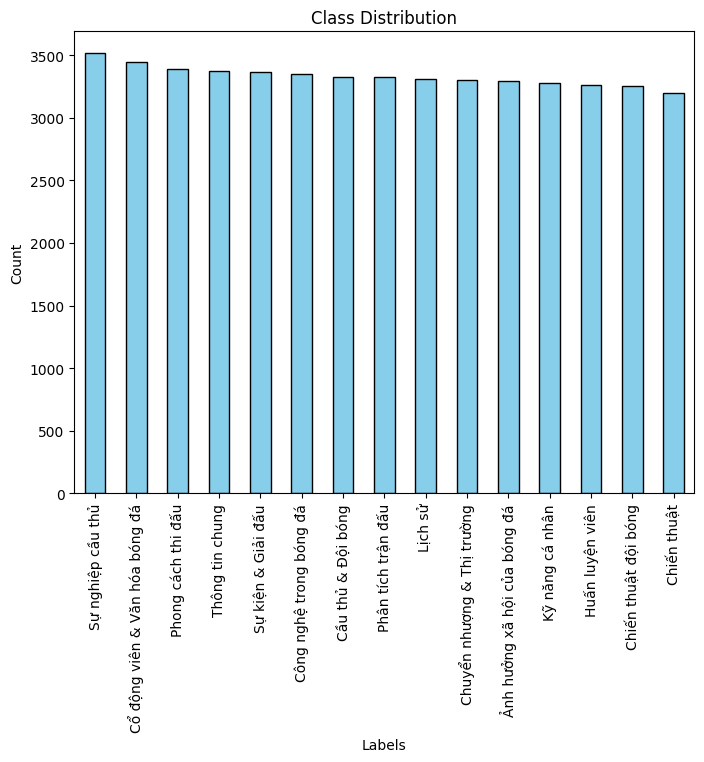

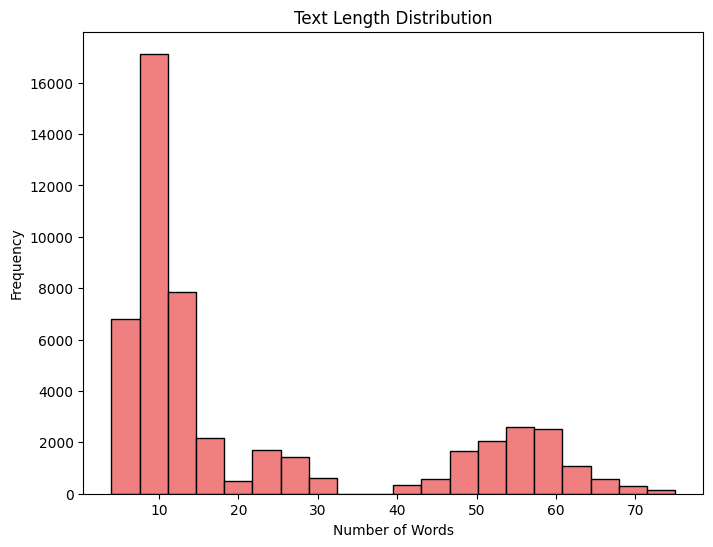


Most common words: [('bóng', 30144), ('nào', 25429), ('trong', 18866), ('có', 18063), ('về', 17697), ('của', 17119), ('những', 16048), ('thế', 15253), ('Thông', 13563), ('tin', 13563)]
Lexical Diversity: 0.0006


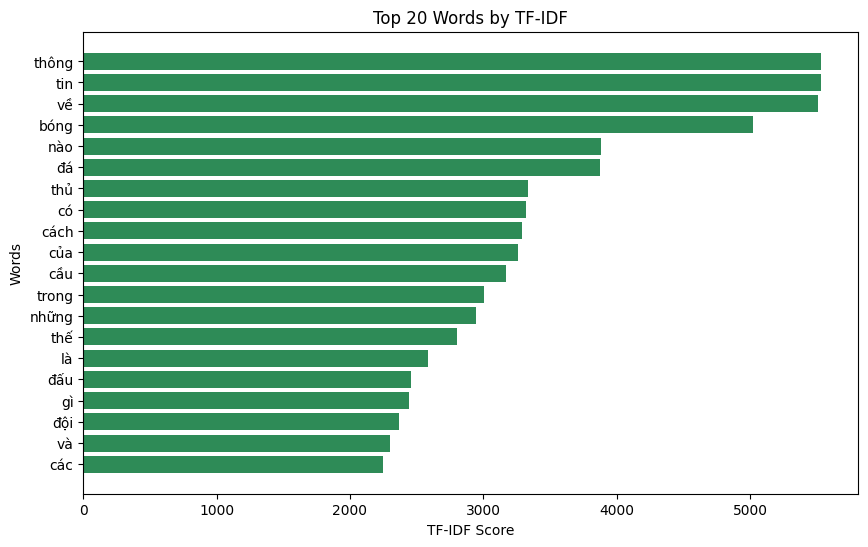

In [17]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    print("\nSample Data:\n", df.head())
    return df

def check_missing_duplicates(df):
    print("\nMissing Values:\n", df.isnull().sum())

def plot_class_distribution(df):
    plt.figure(figsize=(8, 6))
    df['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Class Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.savefig("class_distribution.png")
    plt.show()

def plot_text_length_distribution(df):
    df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(8, 6))
    plt.hist(df['text_length'], bins=20, color='lightcoral', edgecolor='black')
    plt.title("Text Length Distribution")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.savefig("text_length_distribution.png")
    plt.show()

def check_word_frequency(df):
    all_words = " ".join(df['text']).split()
    word_freq = Counter(all_words)
    print("\nMost common words:", word_freq.most_common(10))

    unique_words = len(set(all_words))
    total_words = len(all_words)
    print(f"Lexical Diversity: {unique_words / total_words:.4f}")

def plot_top_tfidf_words(df):
    vectorizer = TfidfVectorizer(max_features=100)
    X_tfidf = vectorizer.fit_transform(df['text'].astype(str))

    tfidf_words = vectorizer.get_feature_names_out()
    tfidf_values = X_tfidf.toarray().sum(axis=0)

    sorted_indices = tfidf_values.argsort()[::-1][:20]
    top_words = tfidf_words[sorted_indices]
    top_values = tfidf_values[sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_words[::-1], top_values[::-1], color='seagreen')
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Words")
    plt.title("Top 20 Words by TF-IDF")
    plt.savefig("tfidf_top_words.png")
    plt.show()

def main():
    file_path = "/content/sample_data/generated_soccer_questions.csv"
    df = load_data(file_path)
    check_missing_duplicates(df)
    plot_class_distribution(df)
    plot_text_length_distribution(df)
    check_word_frequency(df)
    plot_top_tfidf_words(df)

if __name__ == "__main__":
    main()


# Step 3: Data preprocessing and representation

In [23]:
df = pd.read_csv("/content/sample_data/generated_soccer_questions.csv")

# Text Processing Class
class TextProcessor:
    def __init__(self, df):
        self.df = df.copy()
        self.clean_text()
        self.y = self.df["label"].astype(str)

    def clean_text(self):
        self.df["clean_text"] = self.df["text"].str.lower()
        self.df["clean_text"] = self.df["clean_text"].str.replace(r"[{}]".format(string.punctuation), "", regex=True)
        self.df["clean_text"] = self.df["clean_text"].str.replace(r"\d+", "", regex=True)
        self.df["clean_text"] = self.df["clean_text"].apply(lambda x: " ".join(word_tokenize(str(x))))  # ✅ Fix: Use only underthesea

    def tfidf_vectorizer(self, X_train, X_test, max_features=100):
        vectorizer = TfidfVectorizer(max_features=max_features)
        return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

    def bag_of_words_vectorizer(self, X_train, X_test, max_features=100):
        vectorizer = CountVectorizer(max_features=max_features)
        return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

    def one_hot_encoding(self, y_train, y_test):
        encoder = OneHotEncoder(sparse_output=False)
        return encoder.fit_transform(y_train.values.reshape(-1, 1)), encoder.transform(y_test.values.reshape(-1, 1))

# Sample 80% of data
df = df.sample(frac=0.8, random_state=42)
df.reset_index(drop=True, inplace=True)

print("Dữ liệu mẫu:")
print(df.head())

processor = TextProcessor(df)  # Original processor for full dataset

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# Create Processors for Train & Test
processor_train = TextProcessor(pd.DataFrame({"text": X_train_raw, "label": y_train}))
processor_test = TextProcessor(pd.DataFrame({"text": X_test_raw, "label": y_test}))

X_train, X_test = processor_train.df["clean_text"], processor_test.df["clean_text"]

# Vectorization
X_tfidf_train, X_tfidf_test = processor_train.tfidf_vectorizer(X_train, X_test)
X_bow_train, X_bow_test = processor_train.bag_of_words_vectorizer(X_train, X_test)

# Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-Hot Encoding
X_one_hot_train, X_one_hot_test = processor_train.one_hot_encoding(y_train, y_test)

# Shape Summary
print("TF-IDF Shape:", X_tfidf_train.shape)
print("BoW Shape:", X_bow_train.shape)
print("One-Hot Shape:", X_one_hot_train.shape)


Dữ liệu mẫu:
                                                text               label
0  Trong thời đại dữ liệu bóng đá phát triển mạnh...  Phân tích trận đấu
1  Trong sự nghiệp của mình, đội hình mạnh nhất đ...  Cầu thủ & Đội bóng
2  Khi so sánh chiến thuật huấn luyện viên với cá...     Huấn luyện viên
3          Chiến thuật sơ đồ 5-3-2 hoạt động ra sao?         Chiến thuật
4  Có những phương pháp hoặc phần mềm phân tích n...  Phân tích trận đấu
TF-IDF Shape: (32000, 100)
BoW Shape: (32000, 100)
One-Hot Shape: (32000, 15)


# Step 4: Lựa chọn model, training và đánh giá dựa trên các phương thức vector hóa câu từ



Using Bag of Words representation:

Model: Logistic Regression
Accuracy: 0.986375
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       514
           1       1.00      1.00      1.00       521
           2       1.00      0.79      0.88       527
           3       1.00      1.00      1.00       533
           4       1.00      1.00      1.00       534
           5       1.00      1.00      1.00       556
           6       1.00      1.00      1.00       520
           7       1.00      1.00      1.00       516
           8       1.00      1.00      1.00       526
           9       1.00      1.00      1.00       539
          10       1.00      1.00      1.00       538
          11       1.00      1.00      1.00       536
          12       0.84      1.00      0.91       569
          13       1.00      1.00      1.00       541
          14       1.00      1.00      1.00       530

    accuracy                

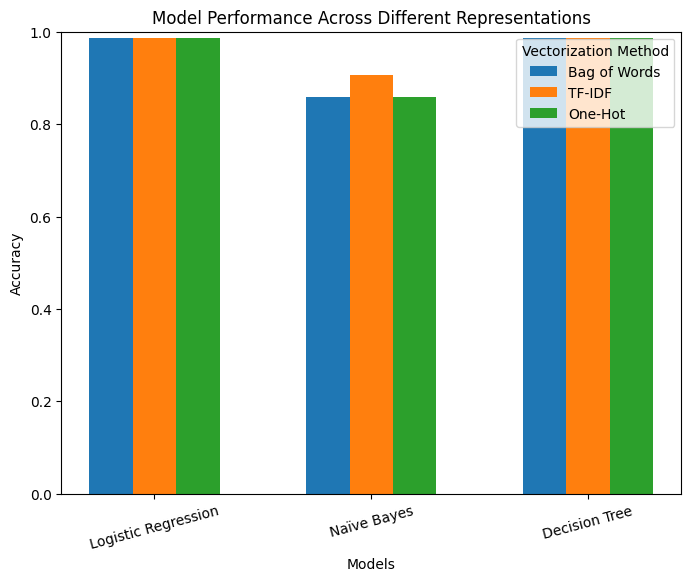

In [19]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naïve Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier()
}

vectorizers = {
    "Bag of Words": (X_bow_train, X_bow_test),
    "TF-IDF": (X_tfidf_train, X_tfidf_test),
    "One-Hot": (X_one_hot_train, X_one_hot_test)
}

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Store accuracy results
accuracy_results = {}

for vec_name, (X_train_enc, X_test_enc) in vectorizers.items():
    print(f"\nUsing {vec_name} representation:")
    accuracy_results[vec_name] = {}

    for model_name, model in models.items():
        print(f"\nModel: {model_name}")

        # Ensure labels are in the correct format
        if vec_name == "One-Hot":
            X_train_enc, X_test_enc = processor.bag_of_words_vectorizer(X_train, X_test)
            y_train_enc, y_test_enc = y_train_encoded, y_test_encoded  # Use LabelEncoder()
        else:
            y_train_enc, y_test_enc = y_train_encoded, y_test_encoded  # Ensure labels are encoded


        model.fit(X_train_enc, y_train_enc)
        y_pred = model.predict(X_test_enc)

        acc = accuracy_score(y_test_enc, y_pred)
        accuracy_results[vec_name][model_name] = acc  # Store accuracy

        print("Accuracy:", acc)
        print("Classification Report:")
        print(classification_report(y_test_enc, y_pred))

# Plot accuracy results
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.2
index = np.arange(len(models))

for i, (vec_name, acc_dict) in enumerate(accuracy_results.items()):
    accuracies = [acc_dict[m] for m in models.keys()]
    ax.bar(index + i * bar_width, accuracies, bar_width, label=vec_name)

ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
ax.set_title("Model Performance Across Different Representations")
ax.set_xticks(index + bar_width)
ax.set_xticklabels(models.keys(), rotation=15)
ax.legend(title="Vectorization Method")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

# Step 5: Doc2Vec


In [20]:
# Load dataset
df = pd.read_csv("/content/sample_data/generated_soccer_questions.csv")

# Preprocess text data
df["text"] = df["text"].str.lower().str.replace(r"[^a-zA-Z0-9 ]", "", regex=True)

# Encode labels
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label_encoded"], test_size=0.2, random_state=42)

# --- Gensim Doc2Vec ---
train_corpus = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]
test_corpus = [text.split() for text in X_test]

gensim_model = Doc2Vec(vector_size=50, window=5, min_count=2, workers=4, epochs=10)
gensim_model.build_vocab(train_corpus)
gensim_model.train(train_corpus, total_examples=gensim_model.corpus_count, epochs=gensim_model.epochs)

X_train_gensim = [gensim_model.infer_vector(doc.words) for doc in train_corpus]
X_test_gensim = [gensim_model.infer_vector(doc) for doc in test_corpus]

# --- Custom PyTorch Doc2Vec ---
class Doc2VecDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = [[vocab.get(w, 0) for w in text.split()] for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

vocab = {word: i+1 for i, word in enumerate(set(" ".join(X_train).split()))}
vocab["<PAD>"] = 0

train_dataset = Doc2VecDataset(X_train, y_train.tolist(), vocab)
test_dataset = Doc2VecDataset(X_test, y_test.tolist(), vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [21]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts  # Already tokenized sequences
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), self.labels[idx]

# Custom collate function for dynamic padding
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0).to(device)  # Apply padding
    labels = torch.tensor(labels, dtype=torch.long).to(device)
    return texts_padded, labels

# Define PyTorch Doc2Vec Model
class SimpleDoc2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SimpleDoc2Vec, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc = nn.Linear(embedding_dim, 50)
        self.bn = nn.BatchNorm1d(50)  # Normalize embeddings for better stability

    def forward(self, x):
        embedded = self.embedding(x)  # Shape: (batch, seq_len, embedding_dim)
        x = embedded.mean(dim=1)  # Average over the sequence length
        x = self.bn(self.fc(x))  # Apply batch normalization
        return x

# Model setup
embedding_dim = 50
vocab_size = len(vocab) + 1  # +1 for padding index
model = SimpleDoc2Vec(vocab_size, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Training function
def train_model(num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Train the model
train_model(num_epochs=5)

# Function to extract document vectors
def get_pytorch_vectors(dataloader):
    model.eval()
    vectors = []
    with torch.no_grad():
        for texts, _ in dataloader:
            outputs = model(texts)  # Get doc vectors
            vectors.append(outputs.cpu().numpy())  # Ensure conversion from GPU to CPU
    return np.vstack(vectors)

# Extract vectors
X_train_torch = get_pytorch_vectors(train_loader)
X_test_torch = get_pytorch_vectors(test_loader)


Epoch 1/5, Loss: 1.0717
Epoch 2/5, Loss: 0.1799
Epoch 3/5, Loss: 0.0773
Epoch 4/5, Loss: 0.0423
Epoch 5/5, Loss: 0.0249


In [22]:
# --- Classifier Evaluation ---
clf_gensim = LogisticRegression(max_iter=500).fit(X_train_gensim, y_train)
y_pred_gensim = clf_gensim.predict(X_test_gensim)
acc_gensim = accuracy_score(y_test, y_pred_gensim)

clf_torch = LogisticRegression(max_iter=10000).fit(X_train_torch, y_train)
y_pred_torch = clf_torch.predict(X_test_torch)
acc_torch = accuracy_score(y_test, y_pred_torch)

print(f"Gensim Doc2Vec Accuracy: {acc_gensim:.4f}")
print(f"PyTorch Doc2Vec Accuracy: {acc_torch:.4f}")

Gensim Doc2Vec Accuracy: 0.6501
PyTorch Doc2Vec Accuracy: 0.1197
